In [1]:
import json
import os
import ml_collections
from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.data_pipeline import seisbench_dataloaders as dataloaders
import matplotlib.pyplot as plt
import tqdm

# config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/pretrain/pretrain_config_rmsnorm_std_nomean_reduce_codevectors_rope.json'
config_path = '/home/liu0003/Desktop/projects/seisLM/seisLM/configs/pretrain/pretrain_config_layernorm_peak_small_batch_6_datasets.json'
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
config = ml_collections.ConfigDict(config)
config.data_config.local_batch_size = 128

#### Override config
config.data_config.amp_norm_type = 'std'
print(config)

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data_config:
  amp_norm: true
  amp_norm_type: std
  cache_dataset: null
  data_name:
  - ETHZ
  - GEOFON
  - STEAD
  - NEIC
  - InstanceCounts
  - Iquique
  demean: true
  local_batch_size: 128
  prefetch_factor: 2
  training_fraction: 1.0
model_config:
  activation_dropout: 0.0
  apply_spec_augment: true
  attention_dropout: 0.0
  codevector_dim: 256
  contrastive_logits_temperature: 0.1
  conv_bias: true
  conv_dim:
  - 256
  - 256
  conv_embed: true
  conv_kernel:
  - 3
  - 3
  conv_stride:
  - 2
  - 2
  diversity_loss_weight: 0.1
  do_stable_layer_norm: true
  feat_extract_norm: layer
  feat_proj_dropout: 0.0
  feat_quantizer_dropout: 0.0
  hidden_dropout: 0.0
  hidden_size: 240
  initializer_range: 0.02
  input_dim: 3
  intermediate_size: 3072
  layer_norm_eps: 1.0e-05
  layerdrop: 0.0
  mask_feature_length: 10
  mask_feature_min_masks: 0
  mask_feature_prob: 0.0
  mask_time_length: 10
  mask_time_min_masks: 2
  mask_time_prob: 0.65
  num_attention_heads: 12
  num_codevector_grou

In [2]:
seed_everything(config.seed)
model = LitMultiDimWav2Vec2(config)

DEFAULT_NUM_WORKERS = 4

data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=config.model_config,
      mask_time_prob=config.training_config.mask_time_prob,
      mask_time_length=config.training_config.mask_time_length,
  )

config.data_config.num_workers = int(
    os.environ.get('SLURM_CPUS_PER_TASK', DEFAULT_NUM_WORKERS))


Seed set to 42


In [3]:
all_data_name = [
      "ETHZ",
      "GEOFON",
      "STEAD",
      "NEIC",
      "InstanceCounts",
      "Iquique"
    ][::-1] # 'ETHZ', 'GEOFON'


for data_name in all_data_name:
  print(f'Processing {data_name}')
  train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
    model=model,
    training_fraction=config.data_config.training_fraction,
    data_names=[data_name],
    batch_size=config.data_config.local_batch_size,
    num_workers=config.data_config.num_workers,
    prefetch_factor=config.data_config.prefetch_factor,
    collator=data_collator,
    cache=config.data_config.cache_dataset,
  )

  for (loader_type, loader) in [('train', train_loader), ('dev', dev_loader)]:
    max_input_values = 0.0
    idx = 0
    for batch in tqdm.tqdm(loader):
      input_values = batch['input_values']
      curr_max = input_values.abs().max().item()
      if curr_max > max_input_values:
        max_input_values = curr_max

      if max_input_values > 100:
        print(f'{loader_type} dataset {data_name} abnormal max_input_values: {max_input_values} > 100 at idx {idx}; break \n')
        break
      idx += 1
    print(f'{loader_type} dataset {data_name} max_input_values: {max_input_values} \n')

2024-08-07 18:50:13,604 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


Processing Iquique


  5%|▍         | 3/62 [00:01<00:25,  2.31it/s]

train dataset Iquique abnormal max_input_values: 915527.3125 > 100 at idx 3; break 



train dataset Iquique max_input_values: 915527.3125 



100%|██████████| 11/11 [00:01<00:00,  6.08it/s]


dev dataset Iquique max_input_values: 22.22224998474121 

Processing InstanceCounts


100%|██████████| 5468/5468 [09:38<00:00,  9.45it/s]


train dataset InstanceCounts max_input_values: 54.605037689208984 



100%|██████████| 899/899 [01:20<00:00, 11.16it/s]


dev dataset InstanceCounts max_input_values: 54.76649856567383 

Processing NEIC


  0%|          | 5/7628 [00:01<27:08,  4.68it/s]  

train dataset NEIC abnormal max_input_values: 10000000000.0 > 100 at idx 5; break 



  0%|          | 5/7628 [00:01<42:52,  2.96it/s]


train dataset NEIC max_input_values: 10000000000.0 



  0%|          | 0/959 [00:00<?, ?it/s]

dev dataset NEIC abnormal max_input_values: 14999999488.0 > 100 at idx 0; break 



  0%|          | 0/959 [00:01<?, ?it/s]


dev dataset NEIC max_input_values: 14999999488.0 

Processing STEAD


100%|██████████| 8404/8404 [12:15<00:00, 11.43it/s]


train dataset STEAD max_input_values: 52.01957702636719 



100%|██████████| 495/495 [00:38<00:00, 12.92it/s]


dev dataset STEAD max_input_values: 38.62377166748047 

Processing GEOFON


100%|██████████| 1260/1260 [02:44<00:00,  7.65it/s]


train dataset GEOFON max_input_values: 52.710594177246094 



100%|██████████| 217/217 [00:26<00:00,  8.06it/s]
2024-08-07 19:18:38,215 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


dev dataset GEOFON max_input_values: 23.173402786254883 

Processing ETHZ


100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


train dataset ETHZ max_input_values: 45.547367095947266 



100%|██████████| 29/29 [00:08<00:00,  3.44it/s]

dev dataset ETHZ max_input_values: 35.200225830078125 



In [4]:
for sample in batch['input_values']:
  if sample.abs().max().item() > 100:
    plt.figure()
    print('abnormal sample')
    plt.plot(sample)
    plt.show()
    break



In [5]:
batch

{'input_values': tensor([[[ 4.8626e-01,  5.0358e-01,  5.1130e-01,  ...,  1.0715e+00,
            1.0630e+00,  1.0245e+00],
          [ 2.3758e-01,  2.8032e-01,  2.8769e-01,  ...,  1.0617e+00,
            1.0440e+00,  1.0466e+00],
          [-4.8485e-02, -4.4222e-02, -2.1283e-02,  ..., -9.8278e-01,
           -9.3778e-01, -9.4973e-01]],
 
         [[-1.8520e+00, -1.8456e+00, -1.8547e+00,  ..., -9.1664e-02,
           -1.3488e-01, -1.1084e-01],
          [ 6.7902e-03, -1.2862e-02, -1.5356e-02,  ...,  1.1553e+00,
            1.0962e+00,  1.1067e+00],
          [ 4.7106e-01,  4.3281e-01,  4.3183e-01,  ...,  1.0677e+00,
            1.3699e+00,  1.3674e+00]],
 
         [[ 3.4515e-01,  3.3220e-01,  3.3345e-01,  ...,  8.6793e-02,
            4.8681e-02,  3.0364e-02],
          [ 2.4288e+00,  2.4106e+00,  2.4099e+00,  ...,  4.2559e-01,
            3.8112e-01,  3.7793e-01],
          [ 8.2110e-01,  8.3672e-01,  8.3413e-01,  ...,  1.5074e+00,
            1.5336e+00,  1.5539e+00]],
 
         ...

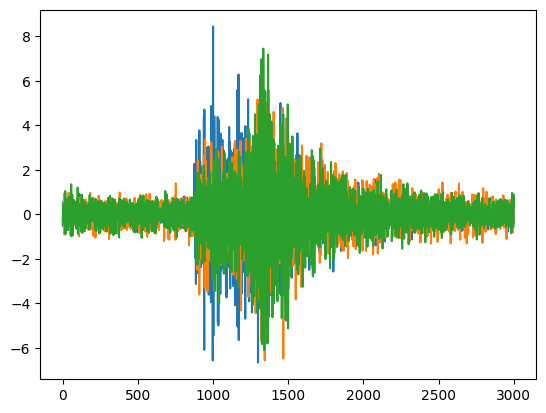

In [6]:
plt.plot( (input_values[idx] / input_values[idx].std()).T)

In [7]:
batch['input_values'].abs().max()

tensor(26.7097)

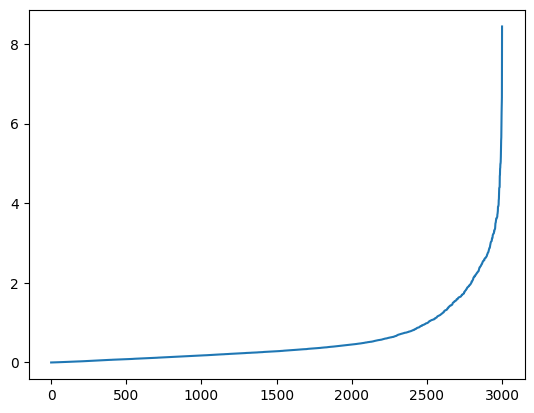

In [8]:
plt.plot(
  batch['input_values'][idx][0].abs().sort().values
)

In [9]:
input_values[idx]

tensor([[-0.4459, -0.5001, -0.1178,  ..., -0.4447, -0.1230,  0.3742],
        [ 0.4502,  0.3516,  0.1287,  ...,  0.3854,  0.0774, -0.2390],
        [-0.3462,  0.2704,  0.4458,  ..., -0.1405,  0.8924,  0.3545]])

In [10]:
len(train_loader)

176